In [1]:
import numpy as np
import matplotlib.pyplot as plt
import celerite

# Celerite example

## A planet around a star

This notebook aims to give an introduction to the use of Celerite and also to give an example of it's application.  We will leave all of the $\mathcal{GP}$ maths behind us in the previous notebook and focus on the application.

We will look at an example (not a very realistic example) of a planet around a star.  The planet creates a radial velocity signal that is deterministic, while the star creates a correlated noise.  Our aim is to estimate the parameters of the radial velocity signal.

In order to keep things as stright forward as possible we will make the RV signal as (no phase, no eccentricity, no ... - it is simple):

$f(t) = A \sin \left( \frac{2 \pi t}{P}\right)$.

From Celerite we will import the Model class from which our own model will inherit properties.  We define the class below:

In [15]:
from celerite.modeling import Model

# Define the model
class MeanModel(Model):
    parameter_names = ("A", "P")

    def get_value(self, t):
        return self.A * np.sin(2.0 * np.pi * t / self.P)
    
model = MeanModel(A = 10.0, P = 340.0)

## Let's make some data

Next we will make some data.  here we use a kernel function as you will have coded in previous examples.  We set up some observations by defining the time array, generating some correlated noise from the kernel, adding the RV model, and then adding some white noise (a small amount of white noise). 

In [19]:
np.random.seed(53)
A = 10.0
P = 340.0
model = MeanModel(A = A, P = P)
theta = [5.0, 250.0]
npts = 150
yerr = np.ones(npts) * 0.1
t = np.linspace(0, 2000, npts)

def kernel(x, y, p):
    # p[0] = sigma
    # p[1] = length scale
    k = p[0]**2 * np.exp(-0.5 * np.subtract.outer(x, y)**2 / p[1]**2)
    return k

y = np.random.multivariate_normal(np.zeros(len(t)), kernel(t, t, theta), 1)[0]
y += model.get_value(t)
y += np.random.randn(len(y)) * yerr

If we now plot the data we will see the difference between the RV signal we wish to recover and the observations.

Text(0,0.5,'v')

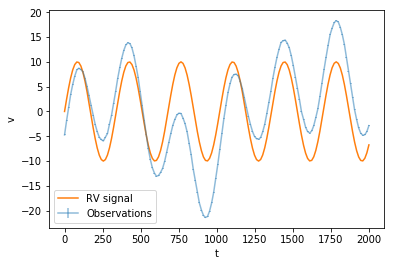

In [21]:
fig, ax = plt.subplots()
ax.errorbar(t, y, yerr=yerr, alpha=0.5, label='Observations')
ax.plot(t, model.get_value(t), label='RV signal')
ax.legend()
ax.set_xlabel('t')
ax.set_ylabel('v')

Our data set is comprised of three components.  A sinusodial planetary signal; correlated noise of stellar origin; uncorrelated 'white' intrumental noise.  

It is straightforward to change the properties of any of the components above and see the impact in the observations.  If you do not have a good feel for the properties of the correlated noise please play with the properties as needed.


## Let's fit the Data the usual way

For now, let's model the data on the assumption that the noise is white.  In order to do this I will make use of the emcee hammer (http://dfm.io/emcee/current/). A detailed explaination of the code is far beyond the scope and the timescale of this exercise but suffice to say the code is an MCMC ensemble sampler.  Please follow the link and ask questions if you know nothing of MCMC.

In order to run this code but keep the footprint of the code to a minimum I have written a like class below.  I have neglected proper priors and kept only the essentials.  This hopefully has the advantage that it is more readable.

After the definition of the class I import the emcee library.  In a few lines of code wemake an instance of the like class (lp), setup some start conditions, and create a smapler instance.

We then 'burn-in' the sampler for an arbitrary number of steps (proper tests for convergence should be used here) and then finally reset the ssmpler befor sampling from what we hope to be the posterior probability distribution.

If all this is a little too much then please ask or refer to the emcee documentation.

In [22]:
class like():
    def __init__(self, t, y, yerr):
        self.y = y
        self.yerr = yerr
        self.t = t

    def model(self, params):
        return params[0] * np.sin(2.0 * np.pi * self.t / params[1])
        
    def __call__(self, params):
        if params[0] < 0:
            return -np.inf
        return np.sum(-0.5 * (y - self.model(params))**2 / yerr**2  )     
            
import emcee

lp = like(t, y, yerr)
initial = np.array([A, P])
ndim, nwalkers = len(initial), 32
p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lp)

print("Running burn-in...")
p0, lp, _ = sampler.run_mcmc(p0, 2000)

print("Running production...")
sampler.reset()
sampler.run_mcmc(p0, 2000);

Running burn-in...
Running production...


We now have samples stored in the sampler that describe the posterior probability density function for the likelihood (and prior function) that we have defined.  We use the corner plot routine to examine the marginalised 1D posteriors and the covariance between both the parameters.

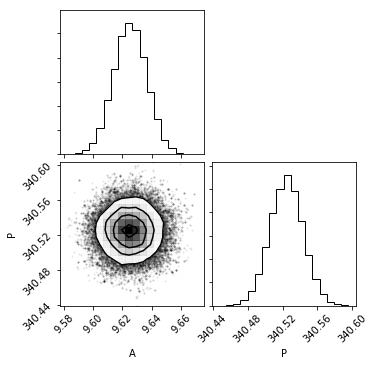

In [23]:
import corner
corner.corner(sampler.flatchain, labels=['A', 'P'])
plt.show()

If you take a look back at the true parameters we input into the simulated data, you will see that the truth is a long way outside of the credible regions for both parameters.  Do you know why this is?

For completeness we will plot the data and the model from this method.

Text(0.5,0,'$t$')

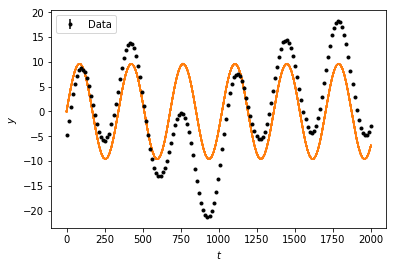

In [28]:
# Plot the data.
fig, ax = plt.subplots()
ax.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, label='Data')
lp = like(t, y, yerr)
# Plot 24 posterior samples.
samples = sampler.flatchain
for s in samples[np.random.randint(len(samples), size=53)]:
    mu = lp.model(s)
    ax.plot(t, mu, color=color, alpha=0.3)
ax.legend()
ax.set_ylabel(r"$y$")
ax.set_xlabel(r"$t$")

## Let's construct a Celerite model

Now let's construct a Celerite model to use a $\mathcal{GP}$ to model the correlated noise.  Setting up this problem in Celerite is strightforward once you know how.  We have a kernel with a single term (but could add more) together with a mean model as defined before.  Having called the compute method we can already print the log likelihood function for the intial parameters we have used.

In [52]:
import celerite
from celerite import terms

bounds = dict(log_a=(-5, 10), log_c=(-10, 5))
kernel = terms.RealTerm(log_a=np.log(np.var(y)), log_c=-np.log(10.0), bounds=bounds)
gp = celerite.GP(kernel, mean=model, fit_mean=True)
gp.compute(t, yerr)  # You always need to call compute once.
print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))

Initial log likelihood: -485.4894775415411


In order to persuade Celerite to talk to emcee, we create a function that returns the log likelihood plus the log prior probability.  In the function we set the gp parameters to params, get the log prior from the gp, and the return the log likelihood plut lp.

Note the if statements that save us computational time.  If the prior is not finite then there is little value to calculating the log likelihood.

In [53]:
def log_probability(params):
    gp.set_parameter_vector(params)
    lp = gp.log_prior()
    if not np.isfinite(lp):
        return -np.inf
    if params[2] < 0:
        return -np.inf
    return gp.log_likelihood(y) + lp

As before, we now setup emcee and run.  

In [54]:
import emcee

initial = gp.get_parameter_vector()
ndim, nwalkers = len(initial), 32
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)

print("Running burn-in...")
p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 2000)

print("Running production...")
sampler.reset()
sampler.run_mcmc(p0, 2000);

Running burn-in...
Running production...


And now show the corner plot:

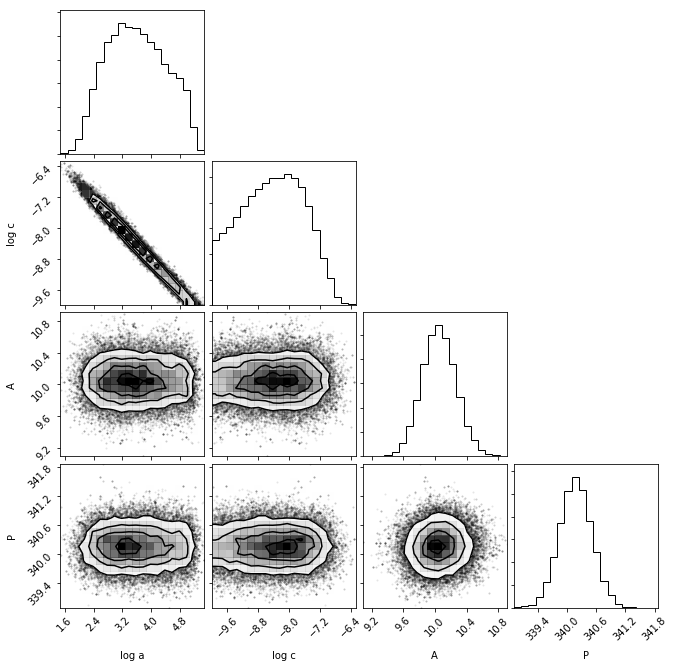

In [57]:
corner.corner(sampler.flatchain, labels=['log a', 'log c', 'A', 'P'])
plt.show()

We can now see the much better agreement between the estimates of the RV parameters and the truth values.  But we can also see that we have estimated the hyperparameters.  

We can use our samples from the posterior probability distribution to plot both the model for the observed data (including correlated noise) and the model for the true RV signal.

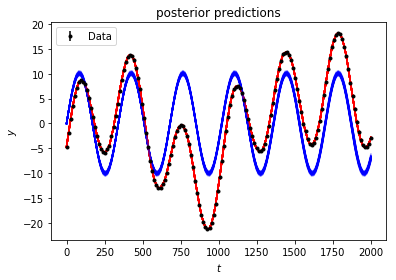

In [58]:
# Plot the data.
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, label='Data')

lp = like(t, y, yerr)
# Plot 24 posterior samples.
samples = sampler.flatchain
for s in samples[np.random.randint(len(samples), size=53)]:
    gp.set_parameter_vector(s)
    mu = gp.predict(y, t, return_cov=False)
    a = plt.plot(t, mu, color='r', alpha=0.3)
    mu = lp.model(s[2:])
    b = plt.plot(t, mu, color='b', alpha=0.3)

plt.ylabel(r"$y$")
plt.xlabel(r"$t$")
plt.legend()
plt.title("posterior predictions");

If you have made it this far, consider applying a Celerite model to a new data set.  Perhaps you have real data that contains correlated noise!